# BRIDGET: ELEC2

River Version


## Dataset Preprocessing


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import json
import yaml
import random
import time
import functools
import pickle
import re
import orjson
import alibi
import ignite
import copy

from IPython import display
from itertools import combinations, product
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections import Counter

import numpy as np
import pandas as pd
import torch.nn as nn
import torch.optim as optimizer

import fatf.utils.data.datasets as fatf_datasets
import fatf.fairness.data.measures as fatf_dfm
import fatf.utils.data.tools as fatf_data_tools

from river import rules, tree, datasets, drift, metrics, evaluate
from river import imblearn
from river import preprocessing
from river import optim
from river import metrics
from river import feature_extraction, feature_selection
from river import ensemble, linear_model, forest, compose

from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader

from ignite.metrics import Accuracy, Loss
from ignite.engine import Engine, Events, create_supervised_trainer, create_supervised_evaluator
from ignite.handlers import EarlyStopping, ModelCheckpoint
from ignite.contrib.handlers import global_step_from_engine


from xailib.models.sklearn_classifier_wrapper import sklearn_classifier_wrapper

from alibi.explainers.cfproto import CounterFactualProto

from bridget_utils import *
from classes import BetaUser, DeferralNet, PyTorchWrapper, RiverModelWrapper
from bridget_mod import BRIDGET, HiC, MiC


c:\Users\virgm\anaconda3\Lib\site-packages\keras\src\export\tf2onnx_lib.py:8: FutureWarning: In the future `np.object` will be defined as the corresponding NumPy scalar.
  if not hasattr(np, "object"):


26-Feb-07 21:06:32 fatf.utils.array.tools INFO     Using numpy's numpy.lib.recfunctions.structured_to_unstructured as fatf.utils.array.tools.structured_to_unstructured and fatf.utils.array.tools.structured_to_unstructured_row.


In [ ]:
dataset = datasets.Elec2()
data = list(dataset)

In [4]:
cols= [item[0] for item in data]
labels= [item[1] for item in data]

df= pd.DataFrame(cols)
df['class'] = labels


df['class'] = df['class'].astype(int)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45312 entries, 0 to 45311
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   date       45312 non-null  float64
 1   day        45312 non-null  int64  
 2   period     45312 non-null  float64
 3   nswprice   45312 non-null  float64
 4   nswdemand  45312 non-null  float64
 5   vicprice   45312 non-null  float64
 6   vicdemand  45312 non-null  float64
 7   transfer   45312 non-null  float64
 8   class      45312 non-null  int64  
dtypes: float64(7), int64(2)
memory usage: 3.1 MB


In [5]:
df['class'].value_counts().sum 

# from the OG  58% DOWN, 42% UP

<bound method Series.sum of class
0    26075
1    19237
Name: count, dtype: int64>

In [6]:
for c in df:
    print(df[c].value_counts().sum)

<bound method Series.sum of date
0.442326    96
0.473563    96
0.867307    96
0.871731    96
0.875979    96
            ..
0.915623    48
0.915667    48
0.915712    48
0.915756    48
0.000133    48
Name: count, Length: 933, dtype: int64>
<bound method Series.sum of day
2    6480
3    6480
4    6480
5    6480
6    6480
7    6480
1    6432
Name: count, dtype: int64>
<bound method Series.sum of period
0.000000    944
0.021277    944
0.042553    944
0.063830    944
0.085106    944
0.106383    944
0.127660    944
0.148936    944
0.170213    944
0.191489    944
0.212766    944
0.234043    944
0.255319    944
0.276596    944
0.297872    944
0.319149    944
0.340426    944
0.361702    944
0.382979    944
0.404255    944
0.425532    944
0.446809    944
0.468085    944
0.489362    944
0.510638    944
0.531915    944
0.553191    944
0.574468    944
0.595745    944
0.617021    944
0.638298    944
0.659574    944
0.680851    944
0.702128    944
0.723404    944
0.744681    944
0.765957    944
0.7872

In [7]:
# Qui definiamo i vari split dei flussi 

#data = df.sample(frac=1, random_state=42).reset_index(drop=True) 
# no shuffle in elec 2 

class_0 = df[df['class'] == 0]
class_1= df[df['class'] == 1]


def stratif(start_point, end_point):
    class_0_perc= class_0.iloc[int(len(class_0)*start_point) : int(len(class_0)*end_point)]
    class_1_perc= class_1.iloc[int(len(class_1)*start_point) : int(len(class_1)*end_point)]

    total = pd.concat([class_0_perc, class_1_perc]).sort_index() # bisogna per forza mantenere l'indice iniziale per l'ordinamento

    return total

In [8]:
#  split ufficiale

calibration_data= stratif(0.6, 0.8)
mic_data= stratif(0.8, 1.0)

avv_train= stratif(0.0, 0.08)
avv_test= stratif(0.08, 0.1)

hic_train= stratif(0.1, 0.55)
hic_test= stratif(0.55, 0.6)

print(len(calibration_data))
print(len(mic_data))

print(len(avv_train))
print(len(avv_test))

print(len(hic_train))
print(len(hic_test))

9062
9063
3624
906
20391
2266


In [9]:
## trasformazione in df perchè servono per il logging e come lookup delle istanze (batch1 e batch3)

df_batch_1 = pd.DataFrame(hic_train).reset_index(drop=True)

df_avv= pd.concat([avv_train, avv_test]).reset_index(drop=True)
df_avv.head(n=5)


,date,day,period,nswprice,nswdemand,vicprice,vicdemand,transfer,class
0,0.0,2,0.000000,0.056443,0.439155,0.003467,0.422915,0.414912,1
1,0.0,2,0.021277,0.051699,0.415055,0.003467,0.422915,0.414912,1
2,0.0,2,0.042553,0.051489,0.385004,0.003467,0.422915,0.414912,1
3,0.0,2,0.063830,0.045485,0.314639,0.003467,0.422915,0.414912,1
4,0.0,2,0.085106,0.042482,0.251116,0.003467,0.422915,0.414912,0


In [10]:
## ora divisione in x e y

target= 'class'

# avviamento 
X_avv_train = avv_train.drop(columns=[target])
y_avv_train = avv_train[target]

X_avv_test = avv_test.drop(columns=[target])
y_avv_test = avv_test[target]


# hic
X_hic_train = hic_train.drop(columns=[target])
y_hic_train = hic_train[target]

X_hic_test = hic_test.drop(columns=[target])
y_hic_test = hic_test[target]
# validation
X_val = calibration_data.drop(columns=[target])
y_val = calibration_data[target]

# mic
X_mic = mic_data.drop(columns=[target])
y_mic = mic_data[target]

## Calibration Phase: Experts and Incremental Model Selection

In [11]:
with open(r".\experts_elec2.yaml", "r") as f:
    config= yaml.safe_load(f)


params_dict= config['experts']['groups']['w_dict']
#feat_order= list(config['experts']['groups']['w_dict'].keys())


### Calibrating Incremental Model

The incremental model to be chosen for Bridget is trained on the X_avv, y_avv portion of the dataset,then evaluated on the X_avv_test and y_avv_test

The calibration phase starts by assessing the results of the learning for several configurations:

    - HoeffdingTreeClassifier

    - ExtremelyFastDecisionTreeClassifier

    - AdaBoostClassifier            (base= SGTClassifier)

    - AdwinBaggingClassifier        (base= SGTClassifier)

    - SRPClassifier                 (base= SGTClassifier)

    - AdaptiveRandomForestClassifier


The metrics observed are the Accuracy, the F1Score and the Counters for the classes

In [12]:
# since all River models work with dicts, lets first transform the dfs to dict
X_avv_df = pd.DataFrame(X_avv_train)
X_avv_test= pd.DataFrame(X_avv_test)

X_avv_dict= X_avv_df.to_dict(orient='records')
X_avv_dict_test= X_avv_test.to_dict(orient='records')


# setting the init params required by HIC class
RULE = True
PAST = True
SKEPT = True
GROUP = False
EVA=    True
N_BINS = 10
N_VAR = 3
MAX = 5

target= 'class'
cats= ['day']
num= [c for c in df if c != target and c not in cats]

test_batch_1= pd.DataFrame(X_hic_test)

test_batch_1['class']= y_hic_test

rule_att = 'period'
rule_value = 0

protected= [c for c in df.columns if c!= target]


In [15]:
# then the models are instantiated and trained by the HiC.train function
# the HiC object is initialized by passing a random user model, its not relevant since it won't interact with the IL anyways

expert= 'accurate_trusting'

sgt_base = tree.SGTClassifier(
    grace_period=100,  # Leggermente più basso per imparare prima
    feature_quantizer=tree.splitter.DynamicQuantizer()
)


htree= tree.HoeffdingAdaptiveTreeClassifier(grace_period= 100)
efdt= tree.ExtremelyFastDecisionTreeClassifier(grace_period=100)
ada= ensemble.AdaBoostClassifier(model= sgt_base, n_models= 8, seed= 42)  
adwin= ensemble.ADWINBaggingClassifier(model= sgt_base, n_models= 8, seed= 42)
srp= ensemble.SRPClassifier(model= sgt_base, n_models=8, seed= 42)
arf= forest.ARFClassifier(n_models= 8, grace_period= 50, max_features='sqrt', seed=42)

models= [htree, efdt, ada, adwin, srp, arf]


for model in models:
    bridget_inst= HiC(expert, df_batch_1, mic_data, test_batch_1, target, expert, protected, cats, num,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, model,  
                0.8, 0.7, 0.0, None)

    
    bridget_inst.train(X_avv_dict, y_avv_train, X_avv_dict_test, y_avv_test)

trained_arf= arf

Accuracy: 42.49%
F1: 59.64%
Distribution of predictions: Counter({1: 906})
HoeffdingAdaptiveTreeClassifier trained
Accuracy: 62.14%
F1: 62.84%
Distribution of predictions: Counter({1: 538, 0: 368})
ExtremelyFastDecisionTreeClassifier trained
Accuracy: 73.62%
F1: 54.99%
Distribution of predictions: Counter({False: 760, True: 146})
AdaBoostClassifier(SGTClassifier) trained
Accuracy: 64.24%
F1: 27.35%
Distribution of predictions: Counter({False: 845, True: 61})
ADWINBaggingClassifier(SGTClassifier) trained
Accuracy: 65.34%
F1: 31.14%
Distribution of predictions: Counter({False: 835, True: 71})
SRPClassifier(SGTClassifier) trained
Accuracy: 49.34%
F1: 62.28%
Distribution of predictions: Counter({1: 832, 0: 74})
ARFClassifier trained


### Calibrating Experts

For the Adult dataset the .search_bounds function was not capable to find the bounds at all, even after doubling the search range and running 10 iters

Thus i pre-trained the IL models first, which update the scaler, then transformed the columns for the expert to be fitted on

In [16]:
## getting a balanced split out of the training section because .fit doesnt really work

temp_data= X_hic_train.copy()
temp_data['target']= y_hic_train

df_0 = temp_data[temp_data['target'] == 0]#.sample(n=(y_hic_train==1).sum(), random_state= 42)
df_1= temp_data[temp_data['target'] == 1]

print(len(df_0))
print(len(df_1))


11734
8657


In [17]:
expert_data= pd.concat([df_0, df_1])#.sample(frac=1, random_state=42).reset_index(drop=True)

X_exp= expert_data.drop(columns=['target'])
y_exp= expert_data['target']


In [18]:
experts_obj= {}

expert_names = ['accurate_trusting', 'accurate_not_trusting', 
                'inaccurate_trusting', 'inaccurate_not_trusting']


for name in expert_names:
    expert_type= config['experts']['groups'][name]

    experts_obj[name]= BetaUser(
        belief_level= expert_type['belief_value'],
        rethink_level= 0.3,
        fairness= True,
        fpr= expert_type['target_FPR'],
        fnr= expert_type['target_FNR'],
        alpha= 0.9,
        
        features_dict= params_dict,
        seed= expert_type['group_seed']
        )
    res = experts_obj[name].fit(X_exp, y_exp, tol= 0.001) # ricorda sempre la f fit vuole un DF
    print(f"{'='*30}")
    print(f" EXPERT CALIBRATION REPORT ")
    print(f"{'='*30}")

    print(f"\n[EXPERT: {name}]")
    print(f"\n[FALSE POSITIVE RATE]")
    print(f"  - Iters:      {res['fpr iters number']}")
    print(f"  - Beta:       {res['calibrated_fpr_beta']:.4f}")
    print(f"  - Target:     {res['target_fpr']}")
    print(f"  - Achieved:   {res['achieved_fpr']:.4f}")

    print(f"\n[FALSE NEGATIVE RATE]")
    print(f"  - Iters:      {res['fnr iters number']}")
    print(f"  - Beta:       {res['calibrated_fnr_beta']:.4f}")
    print(f"  - Target:     {res['target_fnr']}")
    print(f"  - Achieved:   {res['achieved_fnr']:.4f}")
    


 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      8
  - Beta:       -3.9062
  - Target:     0.05
  - Achieved:   0.0498

[FALSE NEGATIVE RATE]
  - Iters:      9
  - Beta:       -1.9531
  - Target:     0.05
  - Achieved:   0.0497
 EXPERT CALIBRATION REPORT 

[EXPERT: accurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      12
  - Beta:       -4.1504
  - Target:     0.05
  - Achieved:   0.0494

[FALSE NEGATIVE RATE]
  - Iters:      11
  - Beta:       -1.8555
  - Target:     0.05
  - Achieved:   0.0490
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_trusting]

[FALSE POSITIVE RATE]
  - Iters:      15
  - Beta:       -2.3865
  - Target:     0.3
  - Achieved:   0.3001

[FALSE NEGATIVE RATE]
  - Iters:      14
  - Beta:       0.6470
  - Target:     0.3
  - Achieved:   0.3007
 EXPERT CALIBRATION REPORT 

[EXPERT: inaccurate_not_trusting]

[FALSE POSITIVE RATE]
  - Iters:      12
  - Beta:       -2.4902
  - Target:     0.3
  - Achieved:   0.3

## BRIDGET decision making

Dopo una prima run di train HIC e testing usando HoeffdingTree e una con EFDT ho deciso di provare la run con ARF, per capire se l'accuracy e F1 iniziali riuscissero a migliorarsi sostanzialmente dopo HiC

### Expert: Accurate, Trusting 

#### HiC

In [19]:
#clean_prepr = copy.deepcopy(prepr_transf)

arf_mod= copy.deepcopy(trained_arf)

current_expert= experts_obj['accurate_trusting']
name= f"{'accurate_trusting'}"


hic_inst= HiC(name, df_batch_1, mic_data, test_batch_1, target, current_expert, protected, cats, num,
                RULE, PAST, SKEPT, GROUP, EVA, N_BINS, N_VAR, MAX, 
                rule_att, rule_value, model,  
                0.85, 0.7, 0.0, None)

In [20]:
hic_df, _, eval_res, accuracy_sc, f1_sc, equality, hic_feas, skept_list, skept_count= hic_inst.start_HiC(df_avv)  

acc_t= pd.DataFrame(hic_df)

acc_t.to_csv(f".\processed_data\elec2\hic_results_ds\hic_{name}", index=False)   

# without XAI, ARF

 20%|█▉        | 4000/20391 [27:17<1:51:48,  2.44it/s] 


KeyboardInterrupt: 

In [ ]:
# before saving the calibration and batch 3 sets, i use the same river scaler to ensure the exact scale is applied

def scale_df(data, pipe, target_c):  # a quanto pare usando questa pipeline di River la label viene persa per strada quindi la devo riattaccarre
    processed_r= []
    labels= data[target_c].values
    X = data.drop(columns=[target_c])

    for i,r in enumerate(X.to_dict(orient='records')):
        scaled_r = pipe.transform_one(r)
        scaled_r[target_c] = labels[i]
        processed_r.append(scaled_r)
    return pd.DataFrame(processed_r)

blueprint= pd.read_csv(r".\processed_data\elec2\hic_results_ds\hic_accurate_trusting")

feat_order = [c for c in blueprint.columns if c not in [
    'ground truth', 
    'proba_model', 'provider', 'machine prediction', 'expert prediction'
]] # ridefinisco l'ordering delle feats prima delle colonne informative 

df_batch_3= scale_df(mic_data, hic_inst.preprocessor, target)
df_batch_3[categoricals]=df_batch_3[categoricals].astype(int)
df_batch_3= df_batch_3[feat_order]

df_calibration= scale_df(calibration_data, hic_inst.preprocessor,target)
df_calibration[categoricals]=df_calibration[categoricals].astype(int)
df_calibration= df_calibration[feat_order]
df_calibration.to_csv(r".\processed_data\elec2\calibration_datasets\acc_t_calibration", index= False)


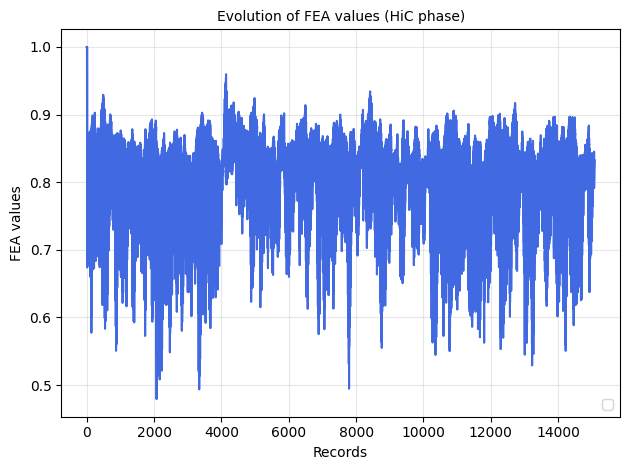

In [ ]:
plt.plot(hic_feas, linestyle='-', color='royalblue')

avg_fea= np.mean(hic_feas)

plt.title('Evolution of FEA values (HiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)

plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)  
plt.tight_layout()
plt.show()

# forgot to change the name again 

#### MiC

In [ ]:
acc_t_switch= pd.read_csv(r".\processed_data\Adult\switch_ds\acc_t_switch")
acc_t_switch = acc_t_switch.rename(columns={'g_truth':'class'})

device = torch.device("cpu")
# prendo la struttura della mic 
mic_net = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=2,dropout_coeff= 0.2) # tanto c'è self.eval quindi il dropout non viene avviato
mic_net.to(device)


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

In [ ]:
X_stream= torch.tensor(data= df_batch_3.drop(columns=['class']).values, dtype=torch.float32).to(device)
y_stream= torch.tensor(data=df_batch_3['class'].values, dtype= torch.long).to(device)


net_path= r".\nets\Adult\acc_t_models\16_8_acc_t_model_30.pt"
mic_net.load_state_dict(torch.load(net_path, map_location=device))

mic_net.eval()


DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=2, bias=True)
  )
)

##### Confidence based Deferral

Tau = 0.88

In [ ]:
acc_t_mic= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.85, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.88, None)


acc_t_mic_df, processed,  mic_acc, model_acc, fea_mic, mach_confidence=acc_t_mic.start_MiC(X_stream, y_stream, acc_t_switch)   #3 minutes

  6%|▌         | 368/6033 [01:48<27:55,  3.38it/s]


 ALERT 

Drift detected, loading metrics...
Current phase: MiC
Current belief_threshold: 0.8
Last 5 FEA values: [np.float64(0.8618158995017466), np.float64(0.8636063172205143), np.float64(0.8653683270993106), np.float64(0.8671025130245485), np.float64(0.5944950472499066)]


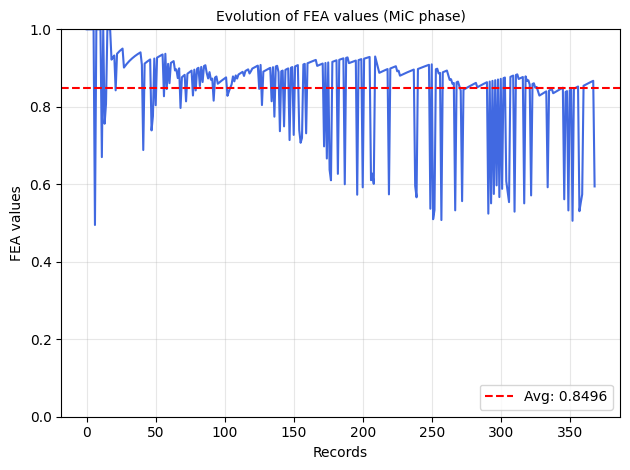

In [ ]:
plt.plot(fea_mic, linestyle='-', color='royalblue')

avg_fea= np.mean(fea_mic)
plt.axhline(y=avg_fea, color='red', linestyle='--', label=f'Avg: {avg_fea:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(mic_acc)
print(model_acc)
print(np.average(fea_mic))
acc_t_mic.deferred_decisions


0.9349593495934959
0.8265582655826558
0.8495554387691213


145

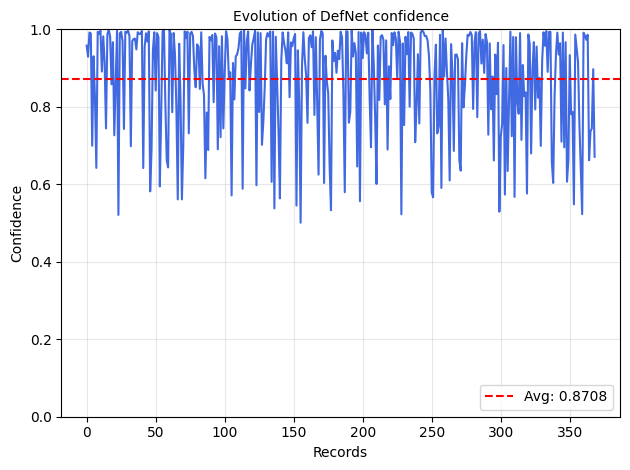

In [ ]:
plt.plot(mach_confidence, linestyle='-', color='royalblue')

avg_conf= np.mean(mach_confidence)
plt.axhline(y=avg_conf, color='red', linestyle='--', label=f'Avg: {avg_conf:.4f}')
plt.title('Evolution of DefNet confidence', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('Confidence', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

##### Two Stage Deferral

Optimal tau= 0.21428612

In [ ]:
r_net_acc_t = DeferralNet(input_size=12, hidden_layer1=16, hidden_layer2=8, output_size=1, dropout_coeff=0.2)


r_net_acc_t.load_state_dict(torch.load(r'r_nets/Adult/r_net_acc_t.pth'))
r_net_acc_t.to(device)
r_net_acc_t.eval() 

DeferralNet(
  (softmax): Softmax(dim=1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=12, out_features=16, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [ ]:
#36 min

acc_t_strat_2= MiC(name, df_batch_1, df_batch_3, test_batch_1, target, clean_prepr, 0.80, current_expert, 
                  protected, categoricals, numericals, 0.8, mic_net, 0.81, anqi_mao_thresh=0.214286)


acc_t_str_2, _,  mic_acc_2, model_acc_2, fea_mic_2, mach_confidence_2=acc_t_strat_2.start_MiC(X_stream, y_stream, acc_t_switch, r_net= r_net_acc_t, two_step_deferral=True)   #3 minutes

100%|██████████| 6033/6033 [36:53<00:00,  2.73it/s]


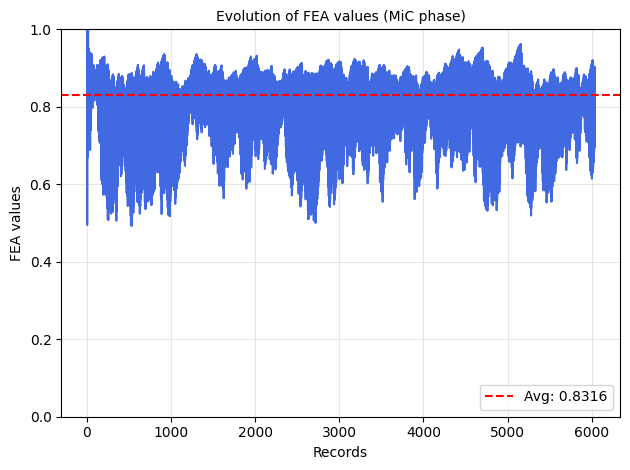

In [ ]:
plt.plot(fea_mic_2, linestyle='-', color='royalblue')
avg_fea_2= np.mean(fea_mic_2)
plt.axhline(y=avg_fea_2, color='red', linestyle='--', label=f'Avg: {avg_fea_2:.4f}')
plt.title('Evolution of FEA values (MiC phase)', fontsize=10)
plt.xlabel('Records', fontsize=10)
plt.ylabel('FEA values', fontsize=10)
plt.ylim(0.0, 1.0)
plt.legend(loc= 'lower right')
plt.grid(True, alpha=0.3)
plt.tight_layout()

plt.show()

In [ ]:
print(mic_acc_2)
print(model_acc_2)
print(np.average(fea_mic_2))
acc_t_strat_2.deferred_decisions



0.8233051549809381
0.8312613956572187
0.831568824287399


489

In [ ]:
acc_t_mic.stats

{False: {'user': {'tried': 79, 'got': 78, 'conf': 1},
  'machine': {'tried': 286, 'got': 190, 'conf': 0}},
 True: {'user': {'tried': 66, 'got': 54, 'conf': 1},
  'machine': {'tried': 83, 'got': 23, 'conf': 0}}}

In [ ]:
acc_t_strat_2.stats

{False: {'user': {'tried': 268, 'got': 268, 'conf': 1},
  'machine': {'tried': 4579, 'got': 3702, 'conf': 0}},
 True: {'user': {'tried': 221, 'got': 104, 'conf': 1},
  'machine': {'tried': 1454, 'got': 893, 'conf': 0}}}